In [1]:
import sys
sys.path.append('..')
from models.scnn_pytorch.model import SCNN
from models.erfnet.erfnet import ERFNet
import torch
import os
import cv2
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt

In [86]:
drive_window_region = np.array([600.0 / 1920, 280.0 / 1080, 1000.0 / 1920, 360.0 / 1080])


def GetRectFromRegion(region: np.array, width, height):
    x = float(width) * region[0]
    y = float(height) * region[1]
    region_width = float(width) * region[2]
    region_height = float(height) * region[3]
    return np.array([x, y, region_width, region_height], dtype=np.int)

rect = GetRectFromRegion(drive_window_region, 1920, 1080)

In [51]:
net = ERFNet(5)
input_mean = net.input_mean
input_std = net.input_std
net= torch.nn.DataParallel(net, device_ids=[0]).cuda()
checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')
net.load_state_dict(checkpoint['state_dict'])
net.eval()
pass

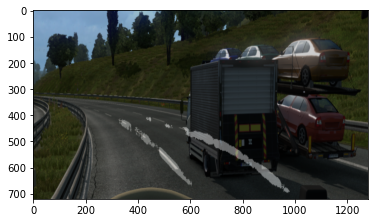

In [85]:
img = cv2.imread('../images/1591496974646.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
#drive_window_img = cv2.copyMakeBorder( drive_window_img, 0, 0, 400, 200, cv2.BORDER_CONSTANT)

input_blob = drive_window_img.astype(np.float)
input_blob = (input_blob - input_mean ) / input_std
input_blob = cv2.resize(input_blob, (976, 208))
input_blob = input_blob.transpose([2, 0, 1])

input_tensor = torch.from_numpy(np.array([input_blob]))
input_tensor = input_tensor.float().cuda()

seg, exist = net(input_tensor)

seg = seg.detach().cpu().numpy()
seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)


seg_img = cv2.cvtColor(seg_img, cv2.COLOR_GRAY2RGB)
seg_img = cv2.resize(seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
drive_window_img = cv2.resize(drive_window_img, (1280, 720))
blend = cv2.addWeighted(seg_img * 50, 0.5, drive_window_img, 0.8, 0)

plt.imshow(blend)